In [2]:
import os
import sys
import random

import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

sys.path.append(os.path.join('..', '..', 'tta_uia_segmentation', 'src'))

from dataset.dataset_in_memory_for_ddpm import get_datasets
from tta_uia_segmentation.src.models.io import load_norm_from_configs_and_cpt
from tta_uia_segmentation.src.dataset.utils import onehot_to_class

def plot_img_seg(
    img, seg, 
    n_classes,
    img_title='Image', 
    seg_title='Segmentation', 
    figsize=(10, 5),
    cmap_classes: str = 'tab20'):
    if seg.max() < 1.0:
        seg = seg * (n_classes - 1)
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray', interpolation='none', vmin=img.min(), vmax=img.max())
    plt.xticks([])
    plt.yticks([])
    plt.title(img_title)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0)
    plt.colorbar(cax=cax)
    
    ax = plt.subplot(1, 2, 2)
    plt.imshow(seg, vmin=0, vmax=n_classes - 1, cmap=cmap_classes, interpolation='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(seg_title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0)
    plt.colorbar(cax=cax)
    

In [2]:
params_fp               = '/scratch_net/biwidl319/jbermeo/logs/wmh/ddpm/normalized_imgs/no_bg_supp_3x3_conv/3_19/batch_size_128_cond_by_concat_multi_gpu/params.yaml'
cpt_fp                  = '/scratch_net/biwidl319/jbermeo/logs/wmh/ddpm/normalized_imgs/no_bg_supp_3x3_conv/3_19/batch_size_128_cond_by_concat_multi_gpu/model-19.pt'
frac_sample_range       = (0.3, 0.7)
dataset                 = 'umc'
seed                    = 1234 
device                  = 'cpu' if not  torch.cuda.is_available() else 'cuda'
split                   = 'train'
mismatch_mode           = 'none' #'same_patient_very_different_labels'  # 'same_patient_very_different_labels', 'same_patient_similar_labels', 'different_patient_similar_labels', 'none'
n_mismatches            = 4
num_t_samples_per_img   = 20
num_iterations          = 100


np.random.seed(seed)
random.seed(seed)

run_params = yaml.safe_load(open(params_fp, 'r'))
dataset_params = run_params['dataset'][dataset]
train_ddpm_cfg = run_params['training']['ddpm']
model_ddpm_cfg = run_params['model']['ddpm_unet']


n_classes = dataset_params['n_classes']

/scratch_net/biwidl319/jbermeo/GNN-Domain-Generalization-main/net_scratch/conda_envs/tta_uia_seg/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Load the normalization model 
norm_dir = train_ddpm_cfg['norm_dir']
params_norm = yaml.safe_load(open(os.path.join(train_ddpm_cfg['norm_dir'], 'params.yaml')))

model_params_norm = params_norm['model']['normalization_2D']
train_params_norm = params_norm['training']

norm = load_norm_from_configs_and_cpt(
    model_params_norm=model_params_norm,
    cpt_fp=os.path.join(norm_dir, train_params_norm['checkpoint_best']),
    device=device    
)

# Let's test each mismatch retrieval mode

In [1]:
train_ddpm_cfg['use_original_imgs']

NameError: name 'train_ddpm_cfg' is not defined

In [4]:
(dataset,) = get_datasets(
        splits          = [split],
        norm            = norm,
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        paths_normalized_h5 = None,
        use_original_imgs = train_ddpm_cfg['use_original_imgs'],
        one_hot_encode  = train_ddpm_cfg['one_hot_encode'],
        normalize       = train_ddpm_cfg['normalize'],
        image_size      = train_ddpm_cfg['image_size'],
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        bg_suppression_opts = None
    )

Determining min and max values of normalized images from a sample of the dataset


Min and max values of normalized images: 0.2939836382865906, 1.2778998613357544


In [5]:
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['lavender', 'tab:brown'])

7 17


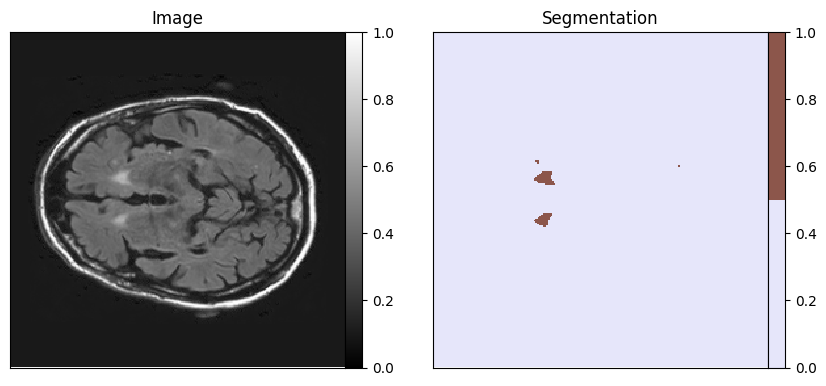

In [6]:
# Sample a random slice
img_size = dataset.dim_proc[0]   # DHW
vol_idx = random.randint(0, dataset.num_vols - 1)
slice_idx = random.randint(int(frac_sample_range[0] * img_size),
                            int(frac_sample_range[1] * img_size))
idx = dataset.vol_and_z_idx_to_idx(vol_idx, slice_idx)
img, seg = dataset[idx]

# plot the original image and segmentation
print(vol_idx, slice_idx)
plot_img_seg(img[0], onehot_to_class(seg[None]).squeeze(), 
             n_classes=n_classes,
             cmap_classes=cmap)

## None

In [21]:
n_mismatches

4

torch.Size([2, 256, 256])


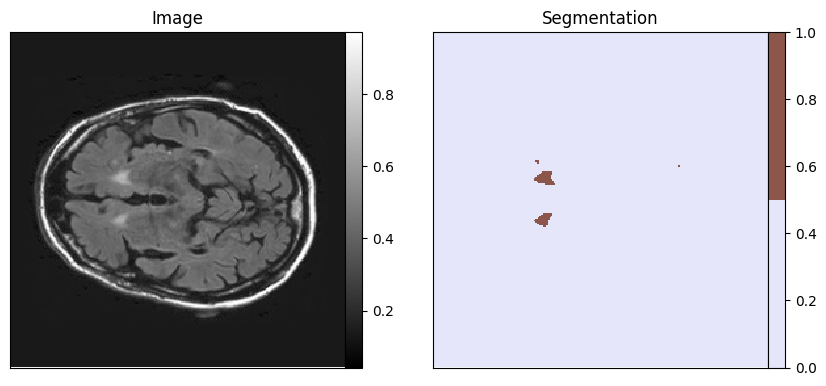

In [24]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='none',
    n=n_mismatches
)

for img, seg in mismatch_ds:
    print(seg.shape)
    plot_img_seg(img[0], onehot_to_class(seg[None]).squeeze(),
                 n_classes, cmap_classes=cmap)

In [8]:
print((seg[0] == 1 ).sum())
print((seg[0] == 0 ).sum())

tensor(65332)
tensor(204)


In [9]:
print((seg[1] == 1 ).sum())
print((seg[1] == 0 ).sum())

tensor(204)
tensor(65332)


## same_patient_very_different_labels

torch.Size([2, 256, 256])
torch.Size([2, 256, 256])
torch.Size([2, 256, 256])
torch.Size([2, 256, 256])


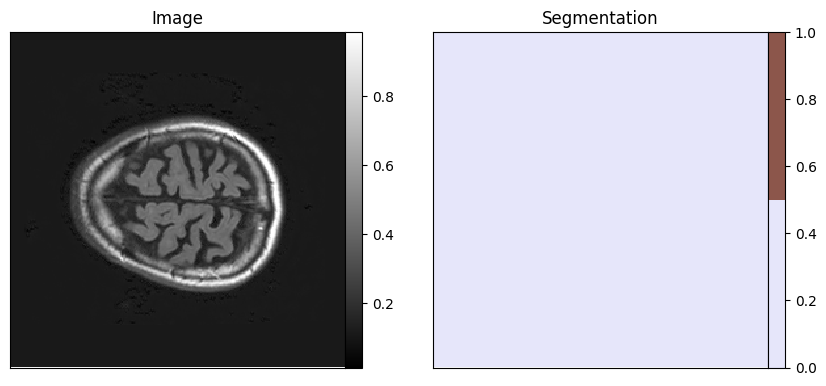

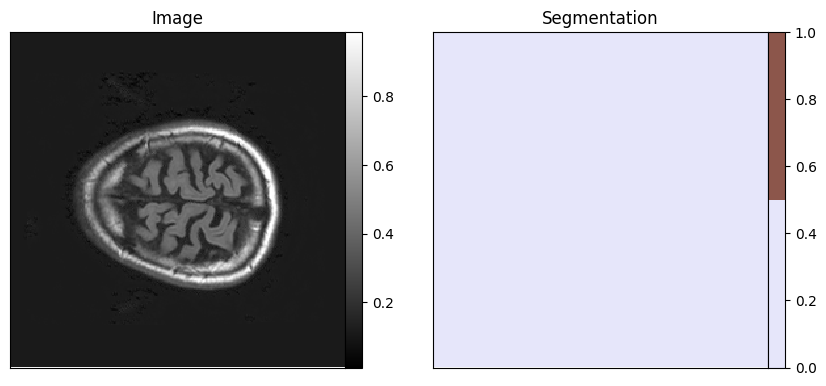

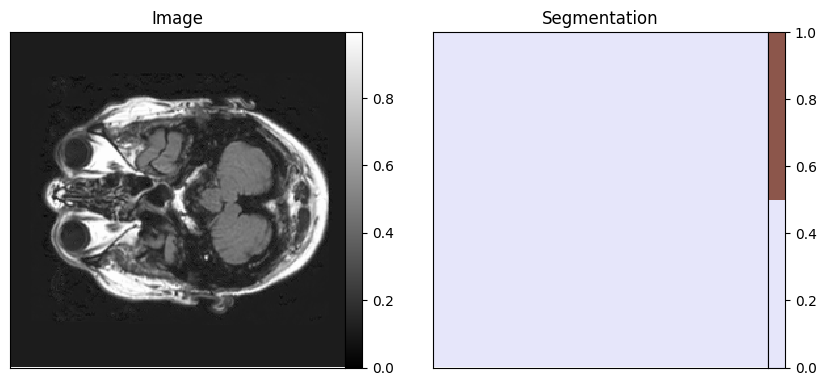

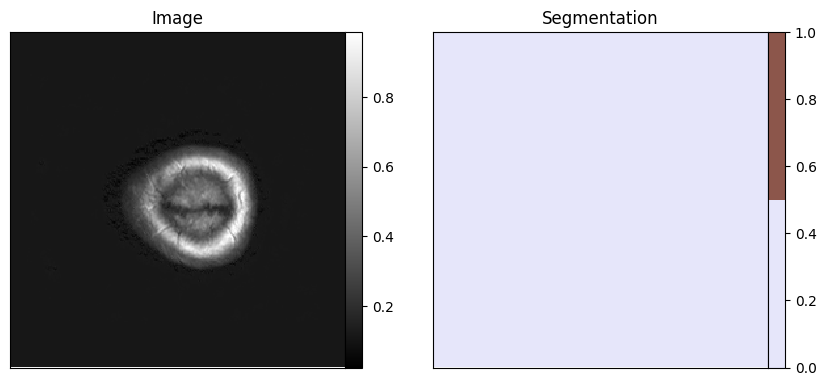

In [10]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='same_patient_very_different_labels',
    n=n_mismatches
)

for img, seg in mismatch_ds:
    print(seg.shape)
    plot_img_seg(img[0], onehot_to_class(seg[None]).squeeze(),
                 n_classes, cmap_classes=cmap)

## same_patient_similar_labels


Dice score too low to use sample:  tensor(0.)
Dice score too low to use sample:  tensor(0.)
torch.Size([2, 256, 256])
torch.Size([2, 256, 256])


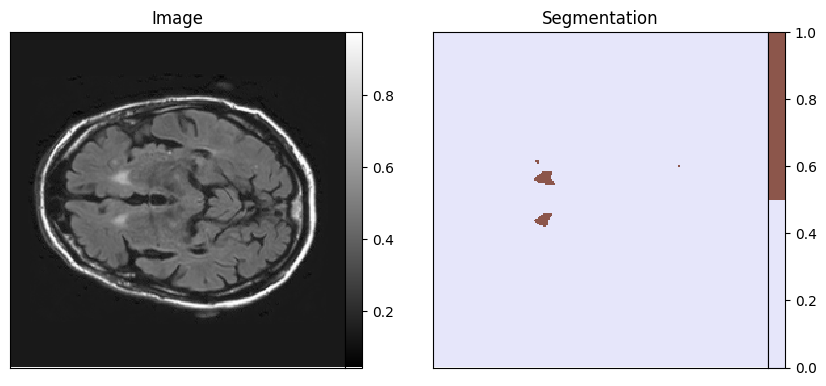

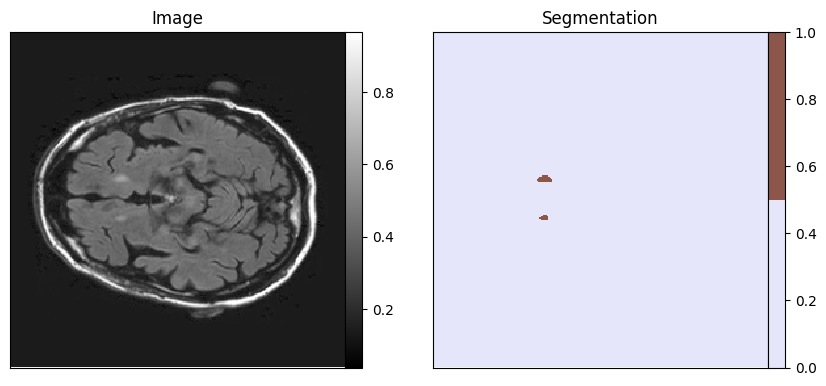

In [15]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='same_patient_similar_labels',
    n=n_mismatches,
    max_dist_z_frac=0.1,
    min_dice_score_threshold=0.5,
)

for img, seg in mismatch_ds:
    print(seg.shape)
    plot_img_seg(img[0], onehot_to_class(seg[None]).squeeze(),
                 n_classes, cmap_classes=cmap)


## different_patient_similar_labels

In [25]:
mismatch_ds = dataset.get_related_images(
    vol_idx=vol_idx,
    z_idx=slice_idx,
    mode='different_patient_similar_labels',
    n=n_mismatches,
    max_dist_z_frac=0.5,
    min_dice_score_threshold=0.4
)

for img, seg in mismatch_ds:
    print(seg.shape)
    plot_img_seg(img[0], onehot_to_class(seg[None]).squeeze(),
                 n_classes, cmap_classes=cmap)

z: 0
z: 1
z: 2
z: 3
z: 4
z: 5
z: 6
z: 7
z: 8
z: 9
z: 10
z: 11
z: 12
z: 13
z: 14
z: 15
z: 16
z: 17
z: 18
z: 19
z: 20


z: 21
z: 22
z: 23
z: 24
z: 25
z: 26
z: 27
z: 28
z: 29
z: 30
z: 31
z: 32
z: 33
z: 34
z: 35
z: 36
z: 37
z: 38
z: 39
z: 40
z: 41
z: 0
z: 1
z: 2
z: 3
z: 4
z: 5
z: 6
z: 7
z: 8
z: 9
z: 10
z: 11
z: 12
z: 13
z: 14
z: 15
z: 16
z: 17
z: 18
z: 19
z: 20
z: 21
z: 22
z: 23
z: 24
z: 25
z: 26
z: 27
z: 28
z: 29
z: 30
z: 31
z: 32
z: 33
z: 34
z: 35
z: 36
z: 37
z: 38
z: 39
z: 40
z: 41
z: 0
z: 1
z: 2
z: 3
z: 4
z: 5
z: 6
z: 7
z: 8
z: 9
z: 10
z: 11
z: 12
z: 13
z: 14
z: 15
z: 16
z: 17
z: 18
z: 19
z: 20
z: 21
z: 22
z: 23
z: 24
z: 25
z: 26
z: 27
z: 28
z: 29
z: 30
z: 31
z: 32
z: 33
z: 34
z: 35
z: 36
z: 37
z: 38
z: 39
z: 40
z: 41
z: 0
z: 1
z: 2
z: 3
z: 4
z: 5
z: 6
z: 7
z: 8
z: 9
z: 10
z: 11
z: 12
z: 13
z: 14
z: 15
z: 16
z: 17
z: 18
z: 19
z: 20
z: 21
z: 22
z: 23
z: 24
z: 25
z: 26
z: 27
z: 28
z: 29
z: 30
z: 31
z: 32
z: 33
z: 34
z: 35
z: 36
z: 37
z: 38
z: 39
z: 40
z: 41
